# Weight mixing

This is a new kind of method to "train" models super fast without having to retrain the entire model again.

This method, introduced with the development of this mod, requires an overfitted model of your own dataset (in our case, `GPT-Neo-125M` combined with the AWSW data we extracted in step 1) + the pretrained model (`GPT-Neo-125M`).

Weight mixing essentialy involves 3 different steps, and can easily be done on CPU in mere seconds, if you manage to get the pretrained weights in advance:

 1. Generate samples from the base model (the model that came pretrained).
 
 2. Add a small amount of gaussian noise to a variable `s`.
 
 3. Do a linear interpolation between the base model and the main model (our own model) using `s` as a mask.
 
 4. Repeat generating samples on this interpolated model
 
     - Are the samples equal? Repeat from step 2.
     - Is even 1 sample different? Quit and move to step 5 (adding more noise to `s`).
   
 5. Now we have the portion that we know we can adjust without the model giving considerably different results. This is what we call the cold zone.
 
     - Using this new mask, we will linear interpolate between the base model and the main model given a user-specified `amount` and `cold_zone_diffusion_steps`.
     
     - `cold_zone_diffusion_steps` will "spread" noise slightly outside the cold zone by blurring, only affecting places that aren't used yet (i.e all the parts that are 0, the rest remains unchanged). The higher the value, the bigger area it will affect.
     
     - `amount` regulates the amount it'll transition between the main and base model.
    
**Note!** `cold_zone_diffusion_steps` can be skipped when not calling calculate_cold_zones, in this case we just do a simple linear interpolation between the 2 models.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager
from model_mixing import ModelMixing
from model_utils import get_model
from config import Config
import matplotlib.pyplot as plt

In [2]:
saved_model_path = os.path.join("models", "awsw_main")
mixed_model_path = os.path.join("models", "awsw_mixed")
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
main_model = AutoModelForCausalLM.from_pretrained(saved_model_path)
base_model, _ = get_model("EleutherAI/gpt-neo-125M")
target_model, _ = get_model("EleutherAI/gpt-neo-125M")
device = torch.device('cpu')
target_model.eval()
model_manager = ModelManager(model=target_model, tokenizer=tokenizer, device=device)
model_manager_main = ModelManager(model=main_model, tokenizer=tokenizer, device=device)
print(f"Loaded base and main model to CPU")

Loaded base and main model to CPU


# Initial test
This will mostly be gibberish. This is intentional, as the target model only contains the pre-trained GPT-Neo weights!

In [3]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]    
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)

def rp_test(model_manager):
    for rp in test_rps:
        print(f'{rp} -> {model_manager.say("", rp)}')
        print("-" * 10)
    print("Lower case test")
    for rp in test_rps:
        rp = rp[0].lower() + rp[1:]
        print(f'{rp} -> {model_manager.say("", rp)}')
        rp = rp.lower()
        print(f'{rp} -> {model_manager.say("", rp)}')
        print("-" * 10)
        
prompt_test(model_manager, do_sample_test = False)

Prompt: How are you?
Reply: park2<msg>Ry "Hello, [player_name]."<p><msg>c "How are you?"<d><scn>park2<msg>Ry "Hello, [player_name]."<p><msg>c "How are you?"<d><scn>park2<msg>Ry "Hello, [player_name]."<p><msg>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>
----------
Prompt: Oh my god, Adine. What is this?
Reply: c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine.
----------
Prompt: What will we do here?
Reply: c "I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure
------

In [4]:
def generate_cold_zone_loss_responses(model_manager):
    for (past, prompt) in prompts:
        yield model_manager.say(past, prompt)
    for rp in test_rps:
        yield model_manager.say("", rp)
        rp = rp[0].lower() + rp[1:]
        yield model_manager.say("", rp)
        rp = rp.lower()
        yield model_manager.say("", rp)

original_target_model_responses = list(generate_cold_zone_loss_responses(model_manager_main))
def cold_zone_loss() -> bool:
    new_responses = generate_cold_zone_loss_responses(model_manager)
    for r1, r2 in zip(original_target_model_responses, new_responses):
        if not r1 == r2:
            print(f"Not correct:\n{r1}\nv.s\n{r2}\n{'-' * 10}")
            return False
        return True

In [5]:
model_mixing = ModelMixing(tokenizer, base_model, main_model, target_model, seed = 45, cold_zone_loss = cold_zone_loss)

# Testing cold zone diffusion

Cold zone diffusion is mission-critical in determining where to mix models. It's gotta work well.

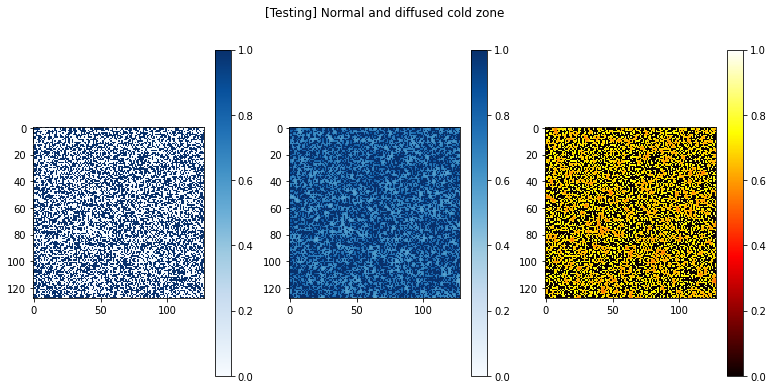

In [6]:
test_cold_zone = np.random.rand(128, 128)
test_cold_zone = np.where(test_cold_zone > 0.5, 1, 0)
test_cold_zone = torch.Tensor(test_cold_zone)
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, 0.5)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('[Testing] Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Calculating the cold zones

Cold zones are the area of the main model that are *safe to adjust* i.e they won't change the answers of the model drastically. Later it's our task to use this cold zone and expand slowly until we get a desired results, coming from both models.

The process requires inference on both models, but no training. It's as slow as the models themselves, but is still feasible on CPU, and we only require samples, .

In [7]:
model_mixing.calculate_cold_zones()

Not correct:
park2<msg>Ry "I'm not sure about that."<p><msg>c "Maybe she actually feels the same way you do, and the map helped her muster up the courage to face you again."<p><msg>c "If you want to change something, Remy, you have to take action. What's the worst that could happen if you talk to her?"<
v.s
park2<msg>Ry "Can I ask you a question?"<|endoftext|>
----------
(restart_tries: 0 amp: 0.90)
Successful #1 cold-zone calculated (amp: 0.91 restart_tries: 1)
Successful #2 cold-zone calculated (amp: 0.90 restart_tries: 0)
Not correct:
park2<msg>Ry "I'm not sure about that."<p><msg>c "Maybe she actually feels the same way you do, and the map helped her muster up the courage to face you again."<p><msg>c "If you want to change something, Remy, you have to take action. What's the worst that could happen if you talk to her?"<
v.s
park2<msg>Ry "Can I ask you a question?"<|endoftext|>
----------
(restart_tries: 0 amp: 0.89)
Successful #3 cold-zone calculated (amp: 0.90 restart_tries: 1)
Su

In [8]:
model_mixing.normalize_cold_zone()

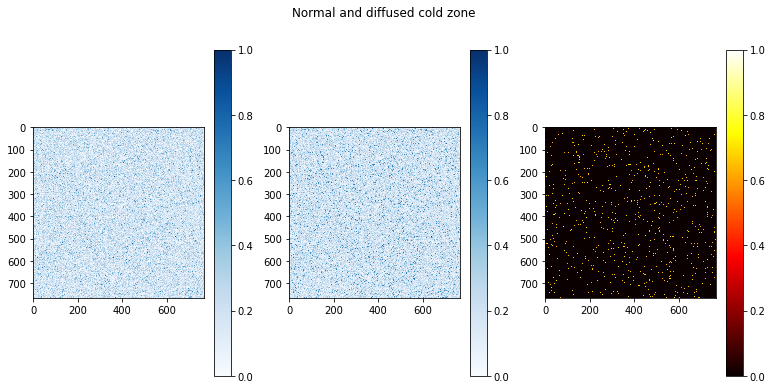

In [9]:
test_cold_zone = model_mixing.cold_zones[5]
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, 0.5)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Let the mixing begin!
The mixing process is the fastest of this whole notebok, and should take just a few seconds on a slow CPU.

In [17]:
model_mixing.mix(0.8, cold_zone_diffusion = 1)

# Testing the mixed model

This model seems to perform as good and in most cases better than a finetuned model in our tests, let's see what it does now!

In [18]:
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure. I suppose you have a point."<d><scn>park2<msg>Ry "Well, what do you think of it?"<p><msg>c "It's pretty romantic."<d><scn>park2<msg>Ry "You think so?"<p><msg>c "I'm not sure
Reply [sampled]: park2<msg>Ry "I guess I judged your portion correctly. Unless you want to go through with this or not."<p><msg>c "I'm already regretting this."<p><msg>c "I'm already regretting this."<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think I should get going now. Thanks for hearing me out, [player_name]."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ry "I think I should get going now. Thanks for hearing me out, [player_name]."<|endoftext|>
Reply [sampled]: park2<msg>Ry "Oh, I see. Just forget I said anything. And by that, I mean everything I've ever said to you."<d><scn>park2<msg>Ry "I'm sorry I didn't realize it sooner."<p><msg>c "I was with Lorem today."<d><scn>park2
----------
Prompt: Oh my god, Adine

In [19]:
rp_test(model_manager)

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight Maverick -> park2<msg>m "Maverick barely avoids my attack and comes rushing towards me"<|endoftext|>
----------
Fight Adine -> beach<msg>m "Adine barely avoids my attack and comes rushing towards me"<|endoftext|>
----------
Attack Adine -> adine<msg>m "Adine barely avoids my attack and comes rushing towards me"<|endoftext|>
----------
Lower case test
visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
visit lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
----------
meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
meet with lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
----------
visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arriv

In [13]:
target_model.save_pretrained(mixed_model_path)